7584
Maximo: 7584


<ipython-input-9-949b72db8d59>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['horario'] = pd.to_datetime(dados['horario'])


Coefficients: %s [ 6.13528654e-04 -9.99069172e-01 -9.98989795e-01  4.21476550e+00]
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 5114
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -10950.064
Date:                            Fri, 09 Jun 2023   AIC                          21908.127
Time:                                    22:27:48   BIC                          21934.267
Sample:                                         0   HQIC                         21917.281
                                           - 5114                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0006      0.01

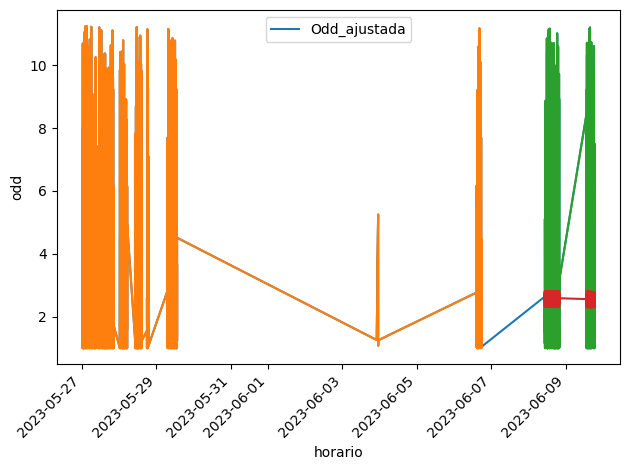

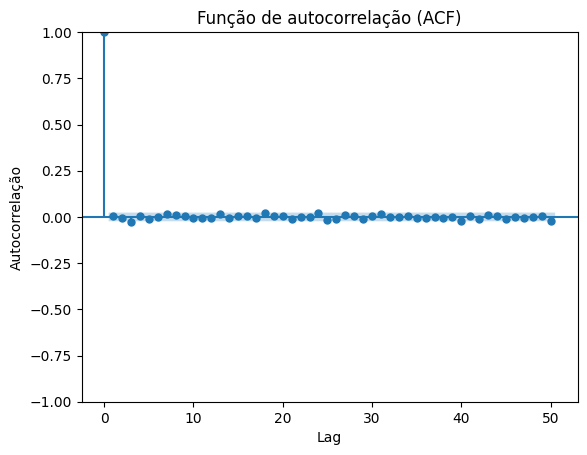

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


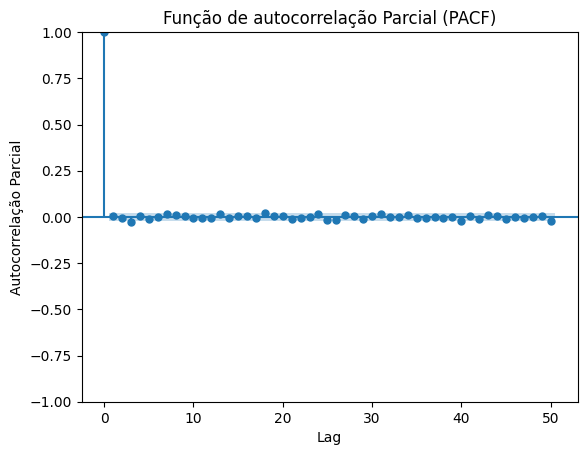

Último número Data:  1.37
[2.63291787 2.679878   2.58859687 2.43625946 2.71885885 2.60501897
 2.37847213 2.64906615 2.7101667  2.5270793  2.73981318 2.29696319
 2.62303108 2.7758397  2.48101821 2.79050808 2.68570263 2.40722744
 2.58525428 2.73199203 2.63526091 2.39950744 2.58039865 2.55181404
 2.63261107 2.6795712  2.58829006 2.43595266 2.71855205 2.60471217
 2.37816533 2.64875935 2.7098599  2.5267725  2.73950638 2.29665638
 2.62272428 2.7755329  2.48071141 2.79020128 2.68539583 2.40692064
 2.58494748 2.73168523 2.63495411 2.39920064 2.58009184 2.55150724
 2.63230427 2.6792644  2.58798326]


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun  8 16:05:13 2023

@author: oziel
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

path = '/content/drive/MyDrive/Aviator/Data1/bd_pseudo_1.csv'
#path = '/run/user/1000/gvfs/google-drive:host=gmail.com,user=ozieljr14/0AAGFG0sJpjdeUk9PVA/1BQG9CYJDzM17YcKGZ2Bv-3yo-ijSYBkO/1BZWZDK2-MdUUKwgiqxS8ZDuDxjsGlLzb/bd_pseudo_1.csv'

data = pd.read_csv(path)

t = 0
print(len(data))
t0 = int(input("Maximo: "))
tamanho_data = len(data)

odd = []
horario = []
odd_ajustada = []

while t <= t0:
    if t < tamanho_data:
        value = data['odd'][t]
        if isinstance(value, float):
            odd.append(np.nan)  # or any other value to represent missing data
        else:
            aux = value.split('\n\n')
            a1 = aux[0].replace(')I', '')
            a2 = a1.replace(')', '')
            a3 = a2.replace('|', '1')
            a4 = a3.replace('?', '7')
            a5 = re.sub('[^0-9.]', '', a4)
            odd.append(float(a5))
        horario.append(data['hora_criacao'][t])

    t += 1

for name in odd:
    ajuste = float(name - 1.25)
    odd_ajustada.append(ajuste)

horas = []
minutos = []
segundos = []
for item in horario:
    dt = datetime.datetime.strptime(item, "%a %b %d %H:%M:%S %Y")
    horas.append(dt.hour)
    minutos.append(dt.minute)
    segundos.append(dt.second)

data1 = pd.DataFrame({'Odd_ajustada': odd_ajustada, 'hora': horas, 'minutos': minutos, 'segundos': segundos, 'horario': horario})

data2 = pd.DataFrame({'horario': horario, 'Odd_ajustada': odd})

dados_filtrados = data2[data2['Odd_ajustada'] < 11.25]

dados = dados_filtrados

#dados = data2

dados['horario'] = pd.to_datetime(dados['horario'])
dados = dados.set_index('horario')
dados.plot()
plt.xticks(rotation=45)
plt.xlabel('horario')
plt.ylabel('odd')
plt.tight_layout()
#
t_treino = dados[dados.index<'2023-06-06 17:36:20'].index.values
t_teste = dados[dados.index>='2023-06-06 17:36:20'].index.values
X_treino = dados[dados.index<'2023-06-06 17:36:20'].values
X_teste = dados[dados.index>='2023-06-06 17:36:20'].values

modelo = SARIMAX(X_treino, order=(1,1,1), seasonal_order=(0,1,1,24))
resultado = modelo.fit()

print('Coefficients: %s', resultado.params)
print(resultado.summary())

X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste,X_pred)

MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

#Plo da ACF
plot_acf(dados['Odd_ajustada'],lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.title('Função de autocorrelação (ACF)')
plt.show()


#Plot da PACF
plot_pacf(dados['Odd_ajustada'],lags = 50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelação Parcial')
plt.title('Função de autocorrelação Parcial (PACF)')
plt.show()

numero = 50
previsao = resultado.get_prediction(start=len(dados), end=len(dados)+numero)

valores_previstos = np.array(previsao.predicted_mean)

print("Último número Data: ", dados_filtrados['Odd_ajustada'].iloc[-1])
print(previsao)
print(valores_previstos)



In [6]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import re
import datetime

path = '/content/drive/MyDrive/Aviator/Data1/bd_pseudo_1.csv'
#path = '/run/user/1000/gvfs/google-drive:host=gmail.com,user=ozieljr14/0AAGFG0sJpjdeUk9PVA/1BQG9CYJDzM17YcKGZ2Bv-3yo-ijSYBkO/1BZWZDK2-MdUUKwgiqxS8ZDuDxjsGlLzb/bd_pseudo_1.csv'

data = pd.read_csv(path)

t = 0
print(len(data))
t0 = int(input("Maximo: "))
tamanho_data = len(data)

odd = []
horario = []
odd_ajustada = []

while t <= t0:
    if t < tamanho_data:
        value = data['odd'][t]
        if isinstance(value, float):
            odd.append(np.nan)  # or any other value to represent missing data
        else:
            aux = value.split('\n\n')
            a1 = aux[0].replace(')I', '')
            a2 = a1.replace(')', '')
            a3 = a2.replace('|', '1')
            a4 = a3.replace('?', '7')
            a5 = re.sub('[^0-9.]', '', a4)
            odd.append(float(a5))
        horario.append(data['hora_criacao'][t])

    t += 1

for name in odd:
    ajuste = float(name - 1.25)
    odd_ajustada.append(ajuste)

horas = []
minutos = []
segundos = []
for item in horario:
    dt = datetime.datetime.strptime(item, "%a %b %d %H:%M:%S %Y")
    horas.append(dt.hour)
    minutos.append(dt.minute)
    segundos.append(dt.second)

data1 = pd.DataFrame({'Odd_ajustada': odd, 'hora': horas, 'minutos': minutos, 'segundos': segundos, 'horario': horario})

data2 = pd.DataFrame({'horario': horario, 'Odd_ajustada': odd})

#dados_filtrados = data2[data2['Odd_ajustada'] < 20]

data = data2

#data = data1

# Verificar se existem valores NaN na coluna "Odd_ajustada"
has_nan = data['Odd_ajustada'].isna().any()
if has_nan:
    print("Existem valores NaN na coluna 'Odd_ajustada'.")
else:
    print("Não existem valores NaN na coluna 'Odd_ajustada'.")

model = Sequential()
model.add(LSTM(50, batch_input_shape=(5,5,10), stateful=True))
model.add(Dense(100, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

data = dados

dados['horario'] = pd.to_datetime(dados['horario'])
dados = dados.set_index('horario')

t_treino = dados[dados.index<'2023-07-11 12:26:11'].index.values
t_teste = dados[dados.index>='2023-07-11 12:26:11'].index.values
X_treino = dados[dados.index<'2023-07-11 12:26:11'].values
X_teste = dados[dados.index>='2023-07-11 12:26:11'].values

model.fit(x_treino)

14017
Maximo: 14017
Não existem valores NaN na coluna 'Odd_ajustada'.


KeyError: ignored